# 基于RFM和K-Means的用户分群
在本项目中，我们基于用户购买数据（Transaction Data)做用户的分群，使用的方法一次是RFM模型和K-means算法。 通过本项目的练习，你即将会学到如何使用RFM和K-means的使用，以及它们之间的区别。 在很多的精准化营销场景，我们经常通过使用RFM模型做用户分群，然后针对于每一类用户做个性化的营销方案。最经典的例子是，把用户分为金牌用户、银牌用户，普通用户等。

- ```使用的数据```：```OnlineClean.xlsx```:  原始是数据：http://archive.ics.uci.edu/ml/datasets/online+retail
本项目中使用的数据是已经经过清洗之后的，原始数据的话需要大量的清洗工作。 所以大家不用担心如何清洗，因为已经都做过了。 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
# 读取transaction数据, 数据有些大，读取会需要点时间，耐心等几秒...
df = pd.read_excel('OnlineClean.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


对于上面的数据稍作解释一下。
- InvoiceNo: 每一次的Transaction的unique number. 比如你去了超市，买了5件东西，那这些东西就构成一个InvoiceNo
- StockCode: 表示的是每一件商品的unique number. 
- Description: 商品的描述
- Quantity: 购买的数量
- InvoiceDate: Transaction的时间
- UnitPrice: 每一件商品的价格
- CustomerID: 用户ID
- Country: 国家

In [3]:
# 对于时间属性做个转换，只保留年月日
df['InvoiceDate'] = df['InvoiceDate'].dt.date

In [4]:
# 一般情况下，在使用RFM模型的时候，一般需要过去一年的Transaction数据。为了提取过去一年的数据，我们首先对时间做一下处理。 
print('Min date = {}, Max date = {}'.format(min(df.InvoiceDate), max(df.InvoiceDate)))

Min date = 2010-12-01, Max date = 2011-12-09


从以上的输出可以看到，时间比一年稍微多点。所以我们就把2010-12-01到 2010-12-09忽略不计，从 2010-12-10开始算到2011-12-09， 这样就刚好一年的时间。 

In [6]:
# 只考虑大于2010-12-09
df = df[df['InvoiceDate']>dt.date(2010,12,9)]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
22523,538172,21562,HAWAIIAN GRASS SKIRT,12,2010-12-10,1.25,15805,United Kingdom
22524,538172,79321,CHILLI LIGHTS,8,2010-12-10,4.95,15805,United Kingdom
22525,538172,22041,"RECORD FRAME 7"" SINGLE SIZE",12,2010-12-10,2.55,15805,United Kingdom
22526,538172,84558A,3D DOG PICTURE PLAYING CARDS,12,2010-12-10,2.95,15805,United Kingdom
22527,538172,22952,60 CAKE CASES VINTAGE CHRISTMAS,24,2010-12-10,0.55,15805,United Kingdom


In [14]:
# 创建一个新的变量，叫做snapshot_date。 举个例子，我们已经有了过去一年的历史数据，然后基于历史数据要计算出R, F, M。 
# 如果历史数据是昨天为止的，那当我们计算R（recency)的时候， 就需要今天 - 历史。 这样一来，今天其实就是昨天日期+1就可以了，这个
# 我们把它叫作snapshot_date
snapshot_date = max(df.InvoiceDate) + dt.timedelta(days=1)
snapshot_date

datetime.date(2011, 12, 10)

In [15]:
# 我们再创建一个column叫作TotalSum, 来表示购买某一种商品的总额
df['TotalSum'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
22523,538172,21562,HAWAIIAN GRASS SKIRT,12,2010-12-10,1.25,15805,United Kingdom,15.0
22524,538172,79321,CHILLI LIGHTS,8,2010-12-10,4.95,15805,United Kingdom,39.6
22525,538172,22041,"RECORD FRAME 7"" SINGLE SIZE",12,2010-12-10,2.55,15805,United Kingdom,30.6
22526,538172,84558A,3D DOG PICTURE PLAYING CARDS,12,2010-12-10,2.95,15805,United Kingdom,35.4
22527,538172,22952,60 CAKE CASES VINTAGE CHRISTMAS,24,2010-12-10,0.55,15805,United Kingdom,13.2


> 到目前为止数据方面的整理工作已经就绪。接下来呢，需要来计算R,F,M的值了。 为了计算R,F,M需要对每一位Customer做Aggregation操作，这部分可以通过```df.groupby```函数来实现。 Recency计算：recency = snapshot_date - 最近一次用户购买日期;  Frequency计算：统计一下过去一年用户购买了多少次，这部分可以统计```InvoiceNo```的总数就可以了。通过```count```函数实现; Monetary计算：过去一年总花费的金额可以累加```TotalSum```字段就可以，使用```sum```函数实现。

- ```问题1```: 创建一个新的dataframe叫作data_rfm, 并包含Recency, Frequency, Monetary字段

In [22]:
# TODO: 写一段Aggregation函数来创建一个新的dataframe，部分代码已经给出
data_rfm = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x:(snapshot_date - x.max()).days,
    'InvoiceNo': lambda x:x.count(),
    'TotalSum': lambda x:x.sum()
}).sort_index(ascending=True)

# 重新命名一下Columns
data_rfm.rename(columns = {'InvoiceDate': 'Recency',
                           'InvoiceNo': 'Frequency',
                           'TotalSum': 'MonetaryValue'}, inplace=True)

data_rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,3,151,3598.21
12348,76,31,1797.24
12349,19,73,1757.55
12350,311,17,334.40


到目前为止，Recency, Frequency, MonetaryValue都是数值型的。 为了用户分群，我们需要把R,F,M的值分别需要映射到bucket中，比如Recency的值映射到1，2，3，4中的某一个数值上； Frequency映射到1，2，3，4中的某一个数值上，MonetaryValue也做同样的处理。 这里需要注意的一点是：值越大就说明用户越有价值，比如R=4的用户要比R=1的用户的价值更大。 所以当我们尝试映射的时候，也需要注意这一点。 因为Recency越大说明好久没有买了，所以这时候映射之后的数要越小； 相反，对于Frequency字段，这个值越大就说明用户购买次数越多，映射之后的值也需要越大； 所以我们需要考虑这一点。 

具体映射时候需要用到的技术在课程里面也讲过，使用quantitle就可以了。 把一组数据通过quantitle分成25%， 50%， 75%点， 这样就可以分成4块了，然后每一块分别赋值，1，2，3，4就可以了。 取quantitle的时候可以直接使用 ```pd.qcut```函数。

> ```问题2：``` 针对于Recency, Frequency, MonetaryValue，把每一个值通过quantitle映射到1，2，3，4不同的bucket里面, 把新的column命名为Recency_Q, Frequency_Q, MonetaryValue_Q

In [23]:
# TODO: 创建三个新的Column, 分别表示R,F,M的quntitle值
Rquartiles = pd.qcut(data_rfm['Recency'], 4, labels=[4,3,2,1])
data_rfm = data_rfm.assign(Recency_Q = Rquartiles.values)

Fquartiles = pd.qcut(data_rfm['Frequency'], 4, labels=[1,2,3,4])
data_rfm = data_rfm.assign(Frequency_Q = Fquartiles.values)

Mquartiles = pd.qcut(data_rfm['MonetaryValue'], 4, labels=[1,2,3,4])
data_rfm = data_rfm.assign(Moneytary_Q = Mquartiles.values)

data_rfm.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q
CustomerID,,,,,,
12346,326,1,77183.60,1,1,4
12347,3,151,3598.21,4,4,4
12348,76,31,1797.24,2,2,4
12349,19,73,1757.55,3,3,4
12350,311,17,334.40,1,1,2


In [24]:
# 创建一个新的column叫作segment， 比如Recency_Q = 1, Frequency_Q = 2, Monetary_Q=4, 则segment为124.
# 实现过程就是直接把每一个值拼接在一起。
data_rfm['Segment'] = data_rfm[['Recency_Q','Frequency_Q','Moneytary_Q']].apply(lambda x: ''.join(x.map(str)), axis=1)
data_rfm.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q,Segment
CustomerID,,,,,,,
12346,326,1,77183.60,1,1,4,114
12347,3,151,3598.21,4,4,4,444
12348,76,31,1797.24,2,2,4,224
12349,19,73,1757.55,3,3,4,334
12350,311,17,334.40,1,1,2,112


> 接下来计算一下RFM_Score。这个值越大说明，说明这个用户价值越大。对于Score可以有不同的计算方式。但在这里我们使用最简单而且最经典的计算方法，其实就是把所有的值加在一起。 比如一个客户的 R=1, F=2, M=3, 则这个客户的RFM_Score为6。

- ```问题3```： 创建一个新的column叫作RFM_Score,  它的值为R,F,M之和。 

In [32]:
[np.sum(list(map(int,list(str(item))))) for item in (data_rfm['Segment'].values)]

[6,
 12,
 8,
 10,
 4,
 10,
 3,
 7,
 4,
 10,
 11,
 9,
 10,
 10,
 3,
 12,
 6,
 10,
 5,
 6,
 10,
 10,
 8,
 4,
 8,
 7,
 7,
 10,
 7,
 11,
 11,
 9,
 7,
 3,
 12,
 6,
 9,
 8,
 7,
 11,
 11,
 9,
 8,
 3,
 3,
 6,
 8,
 11,
 10,
 11,
 10,
 6,
 8,
 7,
 5,
 11,
 12,
 7,
 6,
 10,
 7,
 12,
 7,
 7,
 5,
 7,
 11,
 11,
 5,
 11,
 11,
 12,
 8,
 8,
 5,
 12,
 11,
 6,
 11,
 5,
 8,
 5,
 7,
 11,
 3,
 12,
 8,
 7,
 7,
 9,
 11,
 9,
 7,
 7,
 9,
 8,
 9,
 10,
 6,
 12,
 11,
 11,
 12,
 7,
 12,
 11,
 9,
 8,
 11,
 11,
 11,
 11,
 10,
 4,
 12,
 7,
 5,
 5,
 10,
 6,
 7,
 10,
 9,
 10,
 6,
 4,
 6,
 8,
 3,
 6,
 5,
 6,
 7,
 4,
 7,
 11,
 12,
 6,
 10,
 5,
 5,
 11,
 12,
 10,
 6,
 11,
 9,
 6,
 6,
 8,
 7,
 11,
 7,
 11,
 11,
 9,
 7,
 8,
 9,
 3,
 3,
 8,
 3,
 7,
 12,
 8,
 10,
 6,
 5,
 12,
 3,
 12,
 5,
 3,
 6,
 11,
 12,
 7,
 10,
 4,
 3,
 9,
 9,
 11,
 6,
 5,
 5,
 5,
 12,
 11,
 8,
 6,
 6,
 5,
 7,
 8,
 5,
 6,
 6,
 11,
 6,
 11,
 12,
 9,
 10,
 5,
 4,
 7,
 4,
 9,
 8,
 11,
 8,
 7,
 10,
 5,
 12,
 7,
 8,
 5,
 11,
 10,
 12,
 3,
 5,
 6,
 8,
 11,
 12,


In [33]:
# TODO  创建一个新的column叫作RFM_Score
data_rfm['RFM_Score'] = [np.sum(list(map(int,list(str(item))))) for item in (data_rfm['Segment'].values)]

data_rfm.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q,Segment,RFM_Score
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,4,114,6
12347,3,151,3598.21,4,4,4,444,12
12348,76,31,1797.24,2,2,4,224,8
12349,19,73,1757.55,3,3,4,334,10
12350,311,17,334.40,1,1,2,112,4


有了RFM_Score之后，就可以对用户分群了。 这个值越大，我们可以认为这个用户价值越高。 现在我们希望把用户分层三大类， 金牌客户，银牌客户，以及普通客户，那如何做分群呢？ 一种简单的方法是定义阈值的方式做。比如RFM_Score在某一个区间就认为是金牌客户，银牌客户等等。 在这里，我们就使用这种方法，规则为：

- Gold: RFM_Score >= 9 的时候
- Silver: RFM_Score >= 5 and RFM_Score < 9 的时候
- Normal: RFM_Score < 5

> ```问题4：``` 请创建一个新的Column叫作RFM_Cluster, 然后把每一位客户标记成Gold, Silver, Normal.

In [36]:
# TODO: 创建一个新的column叫作 RFM_Cluster，把每一位客户标记成Gold, Silver, Normal
data_rfm['RFM_Cluster']=data_rfm.apply(lambda x:'Gold' if x['RFM_Score']>=9 else('Silver' if x['RFM_Score']>=5 else 'Normal'), axis=1)

data_rfm.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q,Segment,RFM_Score,RFM_Cluster
CustomerID,,,,,,,,,
12346,326,1,77183.60,1,1,4,114,6,Silver
12347,3,151,3598.21,4,4,4,444,12,Gold
12348,76,31,1797.24,2,2,4,224,8,Silver
12349,19,73,1757.55,3,3,4,334,10,Gold
12350,311,17,334.40,1,1,2,112,4,Normal


In [37]:
# 按照Gold, Silver, Normal来做分群，然后对于每一个群体，统计一下它们的平均Recency, 平均Frequency， 以及平局MoneytaryValue
df_rfm_custom_segment = data_rfm.groupby('RFM_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(1)

df_rfm_custom_segment

,Recency,Frequency,MonetaryValue
RFM_Cluster,,,
Gold,25.9,188.7,4334.3
Normal,205.5,11.0,197.9
Silver,95.4,35.3,722.4


> ```问题5:``` 你觉得上述通过阈值的方式来分群的操作有什么缺点？ 

// 因为Recency 和 Frequency 与MonetrayValue有不同的分布且可能彼此之间相关，通过阈值划分阈值界线来划分数据并不能反映分布上的区分性并且没有考虑数据之间联系



### 基于K-means算法的分群
接下来我们通过使用k-means算法来对用户分群，使用的值仍然是Recency, Frequency, Moneytary Value.
当我们使用k-means算法的时候经常需要做预处理工作，因为算法依赖于距离的计算，而且R,F,M的值的范围差别很大。 

对于预处理，我们做如下2个方面的工作：
1. 即使针对于某一个属性，它的值差别很大，所以我们先使用log transform把值做个转换
2. 使用归一化操作把值映射到 N(0,1)，使用的是```sklearn```里的 ```StandardScaler```。

In [38]:
# 只选取R,F,M的值
data_rfm = data_rfm[['Recency','Frequency', 'MonetaryValue']]

# 1. 先做log transform, +1是为了避免log(0)
data_rfm = np.log(data_rfm+1)

# 2. 归一化操作
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_rfm)
data_rfm = scaler.transform(data_rfm)

In [39]:
data_rfm[0:5]

array([[ 1.52664777, -2.44463928,  3.73013332],
       [-1.8885106 ,  1.04571909,  1.28281977],
       [ 0.40511682, -0.21006894,  0.72884376],
       [-0.64034927,  0.46558321,  0.71102567],
       [ 1.4902314 , -0.67378419, -0.61176813]])

接下来试着使用K-Means算法对R,F,M的值做聚类。 首先，需要选出最合适的K值，这里使用的方法是对于每一个K值计算Distortion score，并把这个值按照K值来可视化，之后根据可视化的结果来选择合适的K值。完整的代码已经给出，只需要运行就可以看到可视化结果。  

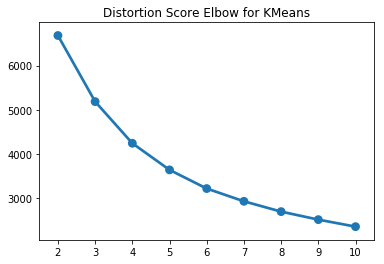

In [41]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=99).fit(data_rfm)
    cluster_labels = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.title('Distortion Score Elbow for KMeans')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [92]:
list1 = [list(sse.values())[iter] - list(sse.values())[iter+1] for iter,item in enumerate(list(sse.values())) if iter < len(list(sse.values()))-1]
list1

[1495.235191982597,
 942.3767902436339,
 602.1071954162303,
 422.4603000414113,
 288.304098569085,
 233.37294518759882,
 181.1815665722993,
 158.782598940737]

```问题6```: 基于以上的这幅图，我们通过Elbow Method来选出3个你认为最好的K值。

// 利用手肘法找到SSE减幅开始变化不明显最小的k值，这时k应该是相对比较合理的值,所以选择最后三个K值6，7，8


```问题7```: 对于每一个K值，训练K-means算法，按照K-means的结果把用户分群，最后展示每一个群体的R, F, M的平均值。 请参考第五题上面的表格。 

In [53]:
from sklearn.cluster import KMeans

In [93]:
# 第一个K值
# TODO:
km1 = KMeans(n_clusters=6)
km1.fit(data_rfm)
prediction1 = km1.predict(data_rfm)


In [94]:
# 第二个K值
# TODO:
km2= KMeans(n_clusters=7)
km2.fit(data_rfm)
prediction2 = km2.predict(data_rfm)

In [95]:
# 第三个K值
# TODO:
km3 = KMeans(n_clusters=8)
km3.fit(data_rfm)
prediction3 = km3.predict(data_rfm)

In [96]:
datas = scaler.inverse_transform(data_rfm)
datas = np.exp(datas) -1
data_new = pd.DataFrame(data=datas, columns=['Recency', 'Frequency', 'MonetaryValue'])


In [97]:
data_new['Member1'] = prediction1
df_rfm_custom_segment1 = data_new.groupby('Member1').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(1)

df_rfm_custom_segment1

,Recency,Frequency,MonetaryValue
Member1,,,
0,205.2,7.9,188.4
1,34.5,22.1,347.6
2,10.9,377.3,10236.3
3,171.5,33.2,589.5
4,11.4,78.0,1240.5
5,64.8,110.0,2116.0


In [98]:
data_new['Member2'] = prediction2
df_rfm_custom_segment2 = data_new.groupby('Member2').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(1)

df_rfm_custom_segment2

,Recency,Frequency,MonetaryValue
Member2,,,
0,197.6,5.9,167.7
1,8.0,398.0,11125.9
2,97.9,53.4,1099.4
3,11.9,72.8,1178.7
4,48.2,156.2,2835.7
5,208.4,23.0,383.2
6,33.2,19.1,311.4


In [99]:
data_new['Member3'] = prediction3
df_rfm_custom_segment3 = data_new.groupby('Member3').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(1)

df_rfm_custom_segment3

,Recency,Frequency,MonetaryValue
Member3,,,
0,27.0,13.3,268.8
1,44.7,151.2,2543.6
2,194.4,21.1,354.0
3,7.1,91.8,1534.0
4,201.8,5.4,163.8
5,9.5,433.6,12523.9
6,137.6,55.1,1412.0
7,36.3,48.1,660.3


In [1]:
prediction3

NameError: name 'prediction3' is not defined

In [113]:

# visualize the KMeans
df = pd.DataFrame(data_new)
df[['Recency','Frequency', 'MonetaryValue']] = np.log(df[['Recency','Frequency', 'MonetaryValue']]+1)

# Standard Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df[['Recency','Frequency', 'MonetaryValue']])
df[['Recency','Frequency', 'MonetaryValue']] = scaler.transform(df[['Recency','Frequency', 'MonetaryValue']])

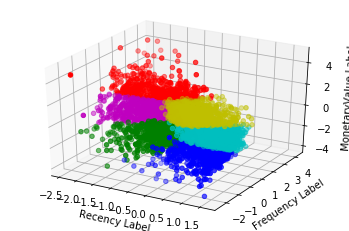

In [114]:
color = ['b','g','r','c','m','y','k','w']
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(6):
    x = df[df['Member1']==i][['Recency', 'Frequency','MonetaryValue']].values[:,0]
    y = df[df['Member1']==i][['Recency', 'Frequency','MonetaryValue']].values[:,1]
    z = df[df['Member1']==i][['Recency', 'Frequency','MonetaryValue']].values[:,2]
    ax.scatter(x, y, z, c=color[i], marker='o')

ax.set_xlabel('Recency Label')
ax.set_ylabel('Frequency Label')
ax.set_zlabel('MonetaryValue Label')
 
plt.show()

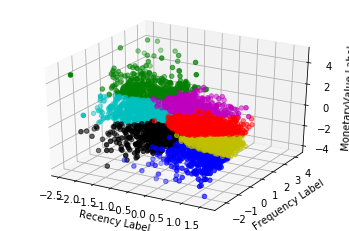

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(7):
    x = df[df['Member2']==i][['Recency', 'Frequency','MonetaryValue']].values[:,0]
    y = df[df['Member2']==i][['Recency', 'Frequency','MonetaryValue']].values[:,1]
    z = df[df['Member2']==i][['Recency', 'Frequency','MonetaryValue']].values[:,2]
    ax.scatter(x, y, z, c=color[i], marker='o')

ax.set_xlabel('Recency Label')
ax.set_ylabel('Frequency Label')
ax.set_zlabel('MonetaryValue Label')
 
plt.show()

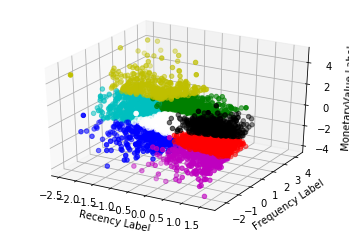

In [116]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(8):
    x = df[df['Member3']==i][['Recency', 'Frequency','MonetaryValue']].values[:,0]
    y = df[df['Member3']==i][['Recency', 'Frequency','MonetaryValue']].values[:,1]
    z = df[df['Member3']==i][['Recency', 'Frequency','MonetaryValue']].values[:,2]
    ax.scatter(x, y, z, c=color[i], marker='o')

ax.set_xlabel('Recency Label')
ax.set_ylabel('Frequency Label')
ax.set_zlabel('MonetaryValue Label')
 
plt.show()